In [1]:
import csv
import numpy as np

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import SGDClassifier

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
input_data = list()
row_count = 0

metadata=list()
with open('../texts/textMetadata.csv', 'rt') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        # deal with the header
        if row_count != 0:
            metadata.append(row)   
        row_count += 1
print("read",row_count,"lines")

read 23 lines


In [3]:
metadata[0]

['crown/RoyalProclamation_HenryVIII_1520.txt',
 'Royal Proclamation',
 '1520',
 'Henry VIII',
 'Crown']

In [4]:
labels = [i[4] for i in metadata]
files = list()
for i in metadata:
    fn = "../texts/" + i[0]
    files.append(fn)
    
vectorizer = CountVectorizer(
    input='filename',
    lowercase=True,
    ngram_range=(1,3),
    strip_accents=None)

In [5]:
# get document term matrix
dtm = vectorizer.fit_transform(files)

# convert to tf-idf frequencies (to account for differences in text lengths)
tfidf_transformer = TfidfTransformer()
dtm_tfidf = tfidf_transformer.fit_transform(dtm)

In [6]:
# attempt to deal with imbalanced dataset

for c in set(labels):
    print("Class: {0}, Documents: {1}".format(c,labels.count(c)))

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced',
                                     np.unique(labels),
                                     labels)

Class: Crown, Documents: 20
Class: Church, Documents: 2


In [7]:
# create and fit model using Support Vector Machine (SVM)
clf = SGDClassifier(tol=None,class_weight="balanced",max_iter=1000).fit(dtm_tfidf, labels)

In [8]:
# this function will return total count of a term in the vocabulary
def get_counts(term):
    widx = vectorizer.vocabulary_[term]
    return(vocab_sums[0,widx])

In [9]:
# what are our top terms?
vocab_sums = dtm.sum(axis=0)
sorted_vocab = [(v, vocab_sums[0, i]) for v, i in vectorizer.vocabulary_.items()]
sorted_vocab = sorted(sorted_vocab, key = lambda x: x[1], reverse=True)

# display top twenty words
for i in range(1,20):
    print(sorted_vocab[i][0],"->",sorted_vocab[i][1])

and -> 62961
of -> 42198
to -> 17788
that -> 16521
in -> 15784
of the -> 13882
he -> 12605
shall -> 11588
for -> 11308
his -> 10307
unto -> 10234
they -> 9189
be -> 9011
lord -> 8818
is -> 8527
them -> 8032
him -> 8000
not -> 7952
the lord -> 7643


In [10]:
feature_names = vectorizer.get_feature_names()
terms = np.argsort(clf.coef_[0])
values = clf.coef_.ravel()[np.argsort(clf.coef_.ravel())]
print("Key features for {}:".format(clf.classes_[0]))
word_cloud_data = list()
for i, t in enumerate(terms):
    # reverse sign
    v = -np.round(values[i],3)
    word_cloud_data.append((feature_names[t],v))
    if i < 50:
        print("{0} ({1})".format(feature_names[t],v),end=", ")

Key features for Church:
thy (1.709), thee (1.023), he (0.872), thou (0.872), him (0.867), unto (0.801), lord (0.747), son (0.647), the lord (0.624), us (0.544), me (0.494), the (0.45), my (0.448), of thy (0.416), holy (0.413), jesus (0.405), christ (0.399), with (0.378), the priest (0.374), and he (0.364), jesus christ (0.352), and (0.324), priest (0.318), for (0.315), his (0.313), came (0.302), israel (0.3), 11 (0.296), was (0.293), up (0.292), sins (0.29), when (0.284), she (0.282), 12 (0.277), 13 (0.268), is (0.261), 10 (0.261), father (0.256), man (0.255), 15 (0.252), ye (0.249), who (0.246), world (0.245), let (0.245), the holy (0.242), 16 (0.238), give (0.236), and the (0.235), the son (0.233), our lord (0.231), 

In [11]:
# reduce data
viz_words = word_cloud_data[:25]+ word_cloud_data[-25:]

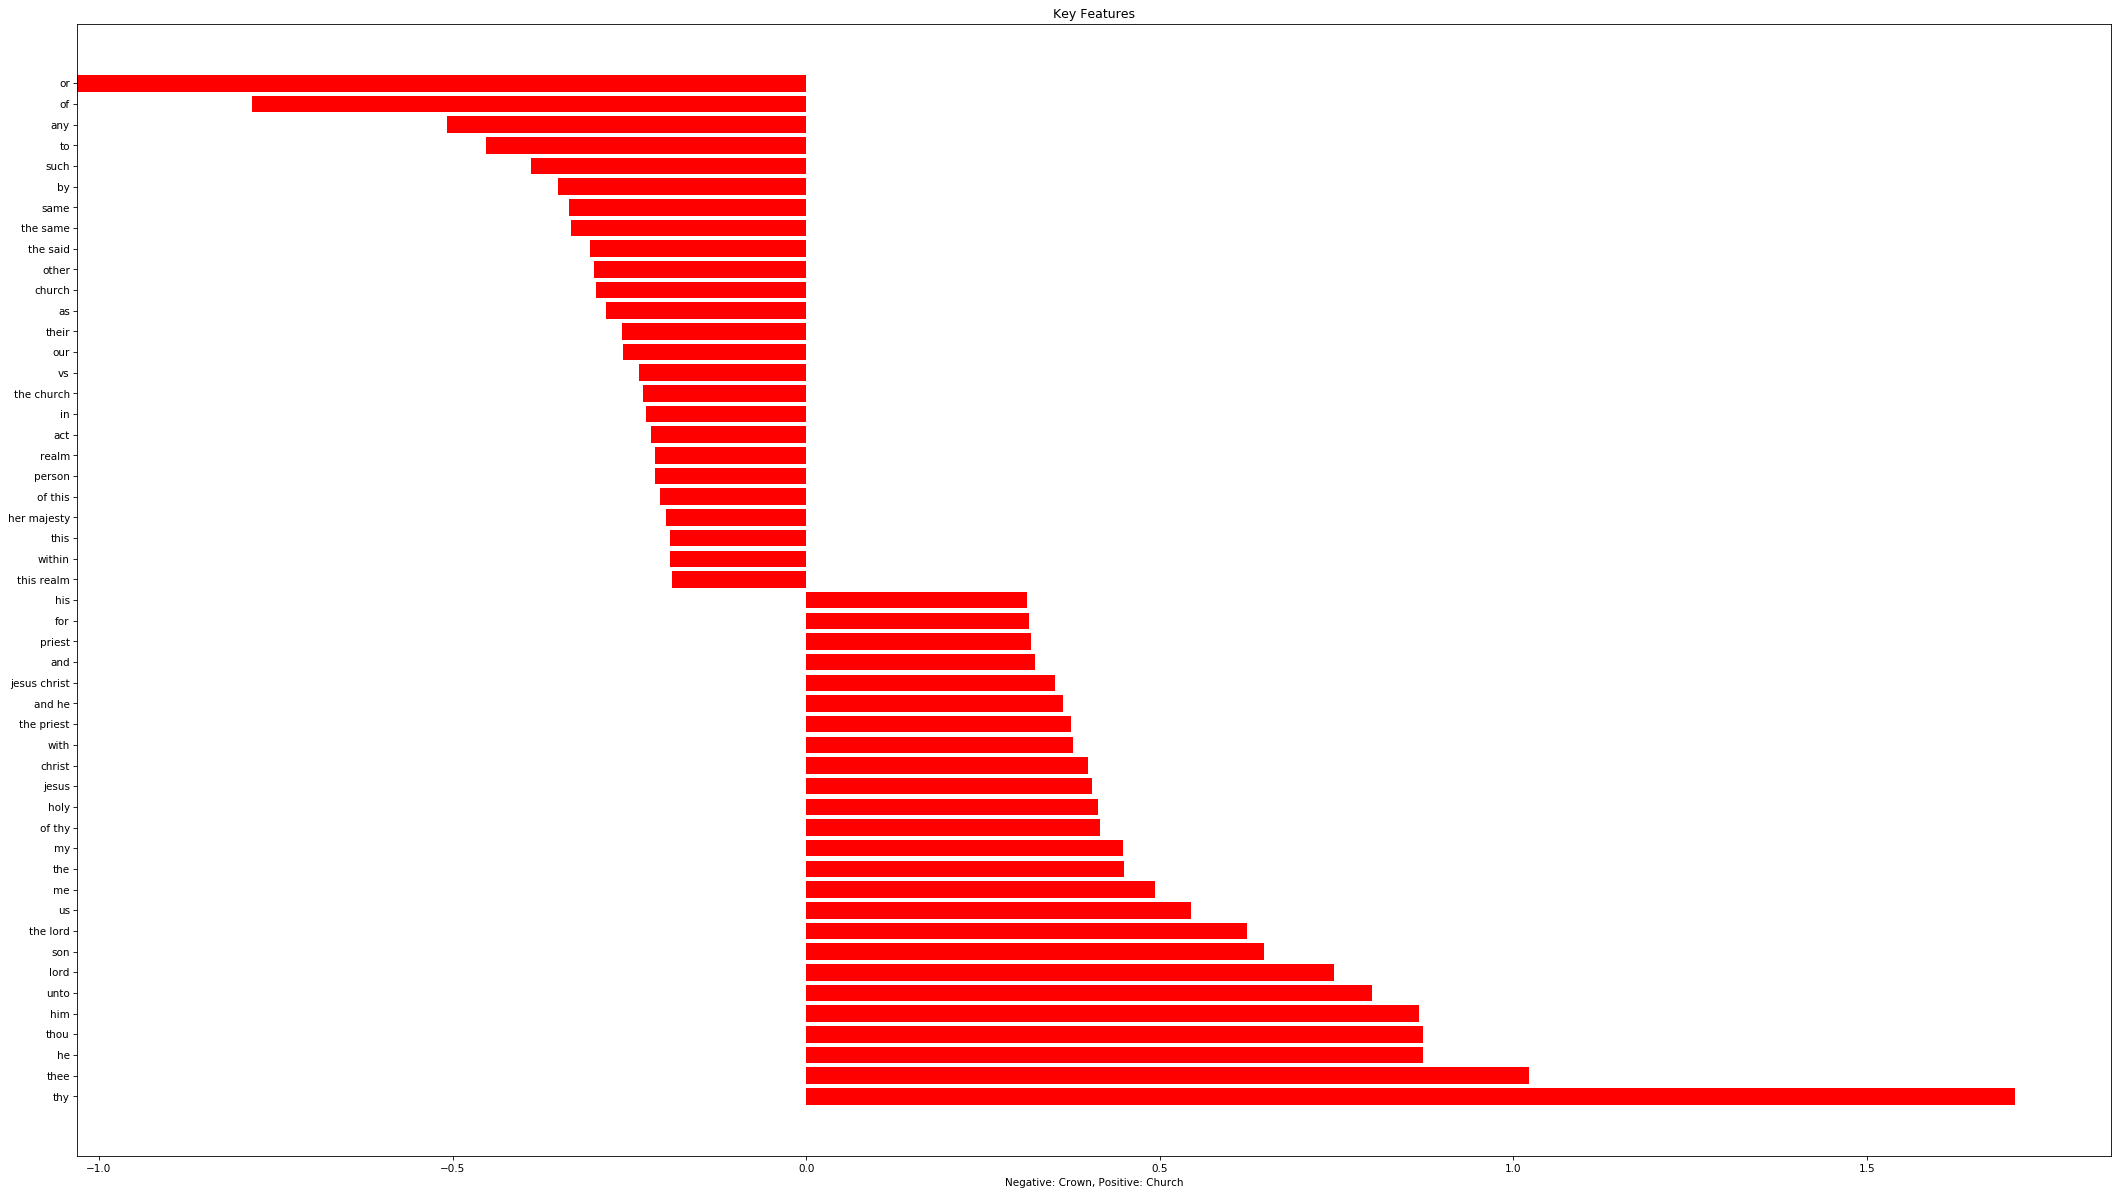

In [14]:
values = [x[1] for x in viz_words]
kwords = [x[0] for x in viz_words]
y_pos = range(len(values))

#fig, ax = plt.subplots()
fig = plt.figure(figsize=(35, 20), dpi=75)
plt.barh(y_pos, values, align='center',tick_label=kwords,color="red")
plt.title("Key Features")
plt.xlabel("Negative: Crown, Positive: Church")
plt.show()

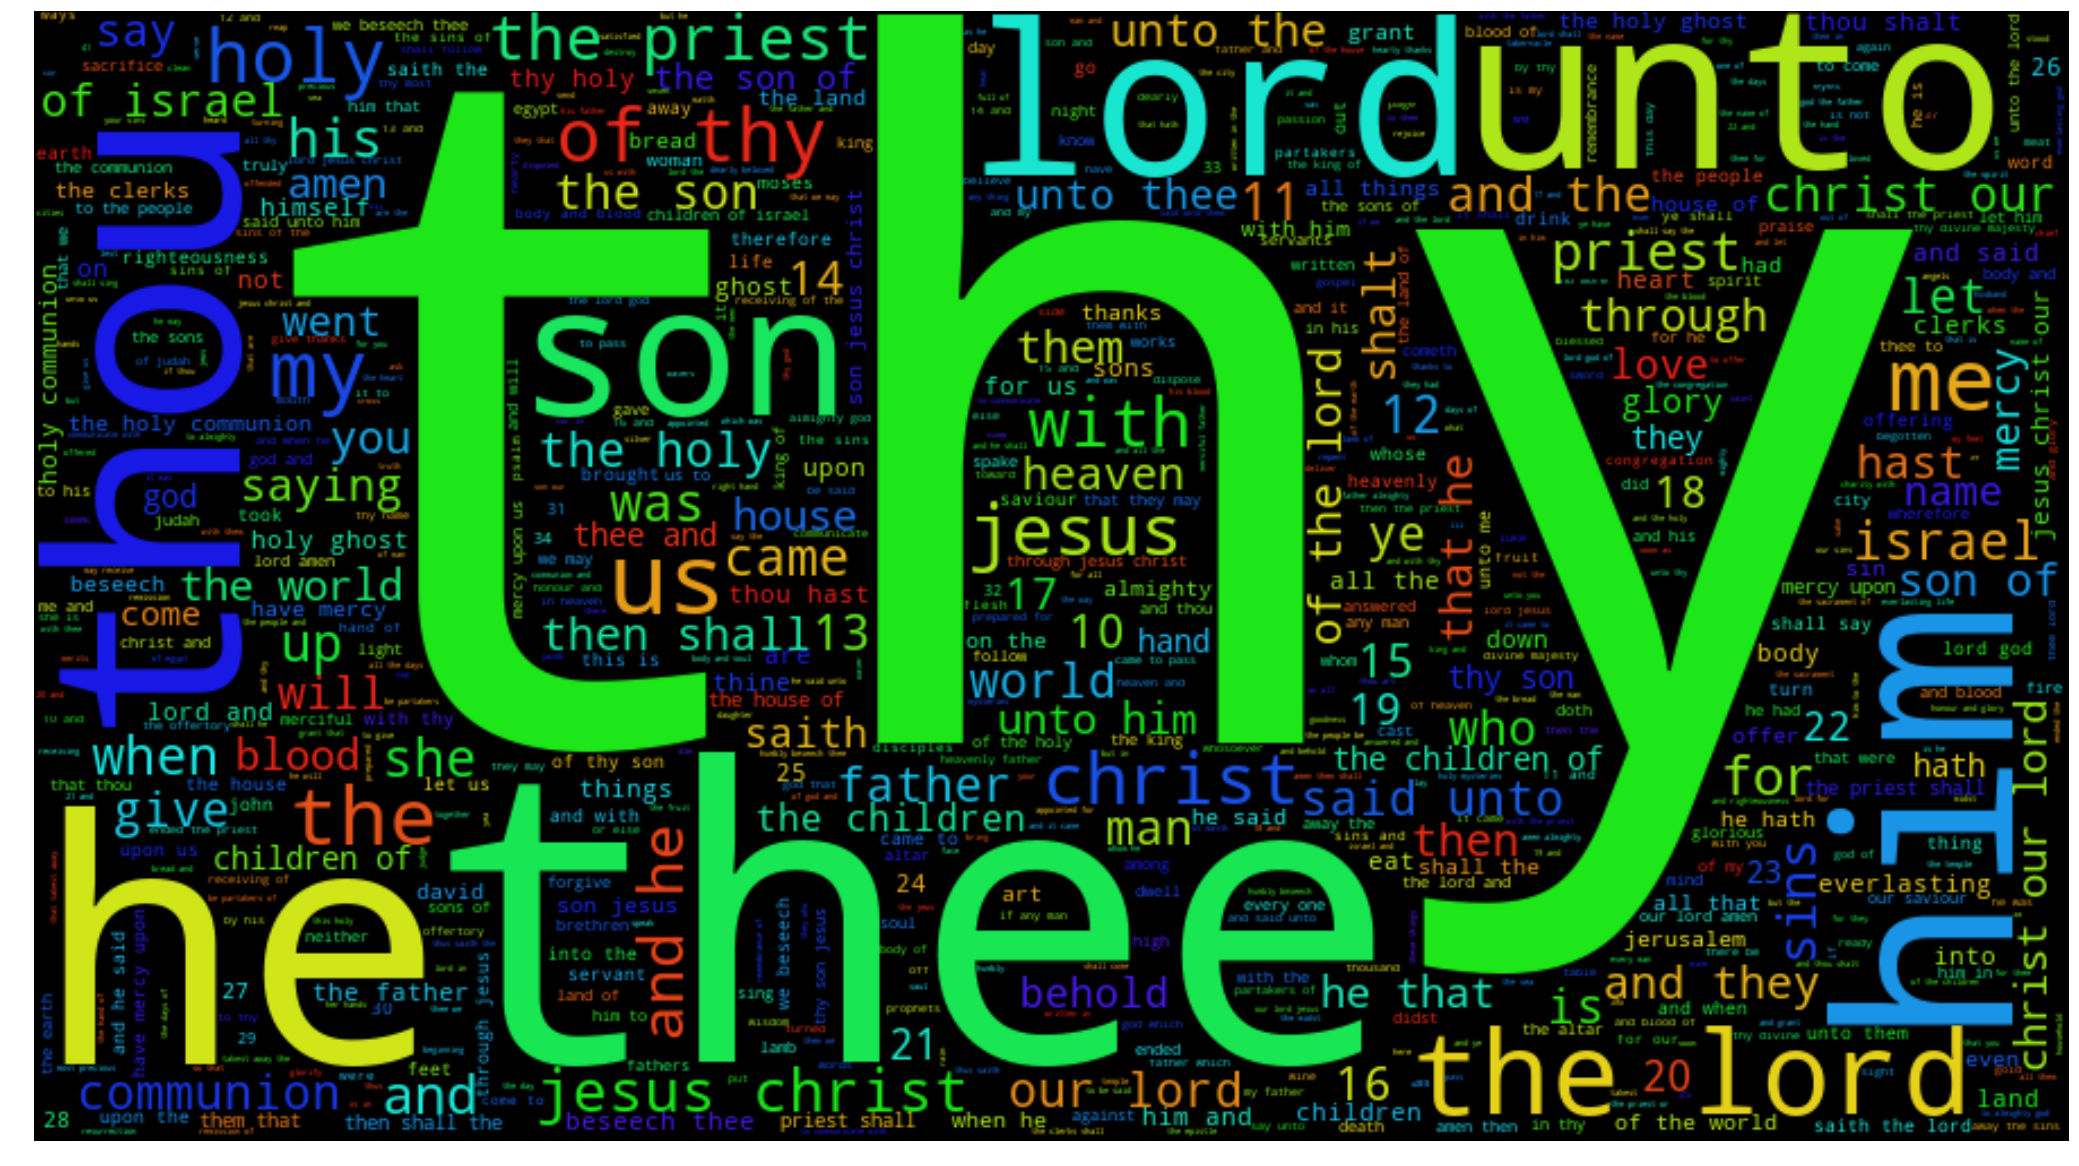

In [13]:
from wordcloud import WordCloud

# show most important features for classification of class Church
fig = plt.figure(figsize=(35, 20), dpi=75)
wordcloud = WordCloud(width=900,height=500, max_words=1000,
                      relative_scaling=1).generate_from_frequencies(word_cloud_data)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()